In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import h5py
import os
import tensorflow as tf
import matplotlib.image as mpimg
from PIL import Image
    
%matplotlib inline

In [4]:
# Read data from file
with h5py.File('./svhnModel/svhnData.h5', 'r') as hf:
    trainingData = hf['trainingData'][:]
    trainingLabels = hf['trainingLabels'][:]
    testData = hf['testData'][:]
    testLabels = hf['testLabels'][:]
print('Training Data Dimension : ',trainingData.shape, trainingLabels.shape)
print('Test Data Dimension : ',testData.shape, testLabels.shape)

Training Data Dimension :  (373257, 32, 32) (373257,)
Test Data Dimension :  (26032, 32, 32) (26032,)


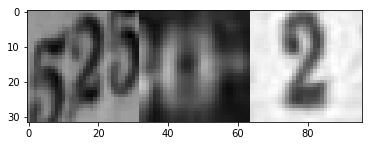

Class Label: 2 0 2


In [5]:
# Show Normalized Samples
randomIdx = random.sample(range(trainingData.shape[0]), 3)
randomImage = trainingData[randomIdx,:,:].transpose(1,2,0)
concatRandomImage = np.concatenate((randomImage[:,:,0],randomImage[:,:,1],randomImage[:,:,2]),axis=1)
plt.figure()
plt.imshow(concatRandomImage[:,:],cmap='gray')
plt.show()
print('Class Label:',trainingLabels[randomIdx[0]],trainingLabels[randomIdx[1]],trainingLabels[randomIdx[2]])

In [6]:
def to4D(data, labels):
  data = data.reshape(
    (-1, data.shape[1], data.shape[2], 1)).astype(np.float32)
  labels = labels.astype(np.int32)
  return data, labels

trainingData, trainingLabels = to4D(trainingData, trainingLabels)
testData, testLabels = to4D(testData, testLabels)

print('Training Data Dimension : ',trainingData.shape, trainingLabels.shape)
print('Test Data Dimension : ',testData.shape, testLabels.shape)

Training Data Dimension :  (373257, 32, 32, 1) (373257,)
Test Data Dimension :  (26032, 32, 32, 1) (26032,)


In [7]:
batch_size = 512
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
num_hidden2 = 16
shape=[batch_size, 32, 32, 1]
num_channels = 1
num_labels = 10
# Construct a 7-layer CNN.
# C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# P2: max pooling layer, batch_size x 14 x 14 x 16
# C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# P4: max pooling  layer, batch_size x 5 x 5 x 32
# C5: convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# F6: fully-connected layer, weight size: 64 x 16
# Output layer, weight size: 16 x 10
graph = tf.Graph()
with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=shape)
  tf_train_labels = tf.placeholder(tf.int64, shape=batch_size)
  tf_test_dataset = tf.constant(testData)
  
  # Variables.
  layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
  layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
  layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')
  layer4_weights = tf.get_variable("W4", shape=[num_hidden1, num_hidden2],\
           initializer=tf.contrib.layers.xavier_initializer())
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='B4')
  layer5_weights = tf.get_variable("W5", shape=[num_hidden2, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5')
  
  # Model.
  def model(data, keep_prob, shape):
    conv = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID', name='C1')
    hidden = tf.nn.relu(conv + layer1_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')
    conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
    hidden = tf.nn.relu(conv + layer2_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')
    conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
    hidden = tf.nn.relu(conv + layer3_biases)
    hidden = tf.nn.dropout(hidden, keep_prob)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    return tf.matmul(hidden, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset, 0.9375, shape)
  loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(model(tf_train_dataset, 1.0, shape))
  test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0, shape))
    
  saver = tf.train.Saver()

In [8]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == labels)
          / predictions.shape[0])

In [9]:
if(tf.train.latest_checkpoint('./svhnModel') == None):
    num_steps = 10000
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print('Initialized')
      for step in range(num_steps):
        offset = (step * batch_size) % (trainingLabels.shape[0] - batch_size)
        batch_data = trainingData[offset:(offset + batch_size), :, :, :]
        batch_labels = trainingLabels[offset:(offset + batch_size)]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0): 
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      save_path = saver.save(session, "CNN_1.ckpt")
      print("Model saved in file: %s" % save_path)

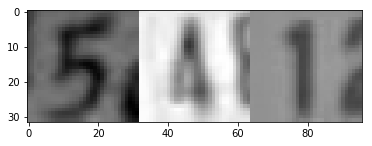

Class Label: 5 4 1


In [10]:
# Prediction
# Randomly pick images from test set
randomIdx = random.sample(range(testData.shape[0]), 3)
randomImage = testData[randomIdx,:,:,:].transpose(1,2,3,0).astype(float)
concatRandomImage = np.concatenate((randomImage[:,:,0,0],randomImage[:,:,0,1],randomImage[:,:,0,2]),axis=1)
plt.figure()
plt.imshow(concatRandomImage,cmap='gray')
plt.show()
print('Class Label:',testLabels[randomIdx[0]],testLabels[randomIdx[1]],testLabels[randomIdx[2]])

INFO:tensorflow:Restoring parameters from ./svhnModel/CNN_1.ckpt


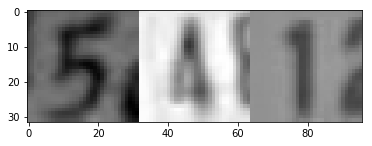

Actual Class Label: [5, 4, 1]
Predicted Class Label: [5, 4, 1]


In [12]:
# Load trained weight
with tf.Session(graph=graph) as session:
    restorer = tf.train.Saver()
    checkpoint_path = tf.train.latest_checkpoint('./svhnModel')
    restorer.restore(session, checkpoint_path)
    batchTestData = testData[randomIdx,:,:,:]
    tf_test_dataset = tf.placeholder(tf.float32, batchTestData.shape)
    prediction = tf.argmax(tf.nn.softmax(model(tf_test_dataset, 1.0, batchTestData.shape)),axis=1)
    feed_dict = {tf_test_dataset : batchTestData}
    predictions = session.run(prediction, feed_dict=feed_dict)
plt.figure()
plt.imshow(concatRandomImage,cmap='gray')
plt.show()
print('Actual Class Label:',[testLabels[randomIdx[0]],testLabels[randomIdx[1]],testLabels[randomIdx[2]]])
print('Predicted Class Label:',predictions.tolist())

In [13]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

(32, 86)


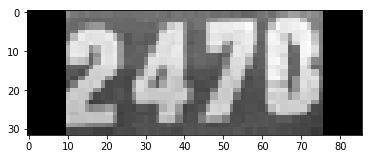

In [14]:
# Apply on multiple digits
# Read Image as Grayscale
testImage = Image.open('test2.jpg').convert('LA')
# Resize to match classifier input size
testImage = np.asarray(testImage.resize((int(round(testImage.size[0]*1.5)),32)))[:,:,0]
# Pad both size (left-right) by zero
testImage = np.lib.pad(testImage, ((0,0),(10,10)), 'constant', constant_values=(0))
print(testImage.shape)
plt.figure()
plt.imshow(testImage,cmap='gray')
plt.show()

Total Window Size :  (55, 32, 32)
Sample Windows


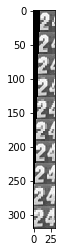

In [15]:
# Employ overlapped sliding window
def slidingWindow(image, stepSize, windowSize):
    output = []
    for row in range(0, image.shape[0] - windowSize +1, stepSize):
        for col in range(0, image.shape[1] - windowSize +1, stepSize):
            output.append(image[row:row + windowSize, col:col + windowSize])
            
    return np.array(output)
windows = slidingWindow(testImage,1,32)
print('Total Window Size : ',windows.shape)
showWindows = windows[0:10,:,:].reshape(32*10,32)
print('Sample Windows')
plt.figure()
plt.imshow(showWindows,cmap='gray')
plt.show()

In [16]:
batchWindows = windows.reshape((-1, windows.shape[1], windows.shape[2], 1)).astype(np.float32)

# Load trained weight
with tf.Session(graph=graph) as session:
    restorer = tf.train.Saver()
    checkpoint_path = tf.train.latest_checkpoint('./svhnModel')
    restorer.restore(session, checkpoint_path)
    batchTestData = batchWindows
    tf_test_dataset = tf.placeholder(tf.float32, batchTestData.shape)
    prediction = tf.nn.softmax(model(tf_test_dataset, 1.0, batchTestData.shape))
    feed_dict = {tf_test_dataset : batchTestData}
    predictions = session.run(prediction, feed_dict=feed_dict)
outputProb = np.max(predictions, axis=1)
outputLabel = np.argmax(predictions, axis=1)
print('Highest probability and class label for each window')
print(outputProb)
print(outputLabel)

INFO:tensorflow:Restoring parameters from ./svhnModel/CNN_1.ckpt
Highest probability and class label for each window
[ 0.99966919  0.99983418  0.99938893  0.99842393  0.99707961  0.99115002
  0.98047799  0.95117843  0.94676268  0.77645665  0.93601179  0.88707381
  0.86485094  0.50124002  0.92533398  0.98380995  0.99951887  0.99991703
  0.99994612  0.99995434  0.99992156  0.99947363  0.98214573  0.94534725
  0.4792726   0.50710124  0.26195556  0.41214347  0.66139823  0.40241775
  0.34359398  0.41455621  0.72554964  0.95835906  0.9895733   0.99259758
  0.99850249  0.9973532   0.99158865  0.98031873  0.95016903  0.4708761
  0.48632458  0.74030387  0.70437038  0.883394    0.68487763  0.68119478
  0.98106658  0.99436355  0.99463475  0.99601585  0.99760985  0.99715281
  0.95253813]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 1 1 4 9 2 2 9 7 7 7 7 7 7
 7 7 7 7 7 4 1 1 1 1 0 0 0 0 0 0 0 0]


In [17]:
# Apply Non Maximum Suppression (NMS)
# Taken from http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def nms(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    prob = boxes[:,4]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by probablity of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(prob)[::-1]
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return np.array(boxes[pick].astype("int"))

In [18]:
# Build bounding box and probality list
bboxes = []
idx = 0
for row in range(0, testImage.shape[0] - 32 +1):
        for col in range(0, testImage.shape[1] - 32 +1):
            if(outputProb[idx] > 0.90):
                bboxes.append([col,row,col+31,row+31,outputProb[idx],outputLabel[idx]])
            idx+=1
selectedBBoxes = nms(np.array(bboxes),0.7)

# Sort keep bboxes by x pos
sortByXPosIdx = np.argsort(selectedBBoxes[:,0])

predictedOutput = selectedBBoxes[sortByXPosIdx][:,5].tolist()

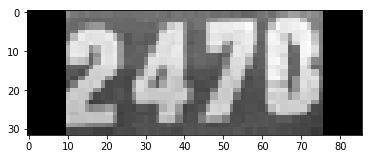

Predicted Output :  [2, 4, 7, 0]


In [19]:
plt.figure()
plt.imshow(testImage,cmap='gray')
plt.show()
print('Predicted Output : ',predictedOutput)